In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
import os
import seaborn as sns
import numpy as np

In [2]:
stations = gpd.read_file('data/stations_ratio_buffer.geojson')

In [14]:
# 确保有唯一字段用于标识站点
id_col = "NLC"  # 或 station_id，视你的字段命名而定

# 2. 定义 12 类 POI
categories = [
    "Residential", "Employment", "Commercial", "Catering", "Leisure", "Sport",
    "Medical", "Education", "Hotel", "Park", "Attraction", "Busstop"
]

# 3. 初始化统计结果 DataFrame
station_counts = stations[[id_col, "geometry"]].copy()

# 4. 循环处理每一类 POI
for category in categories:
    poi_path = f"data/cleaned_poi_2022/{category}_all.geojson"
    if not os.path.exists(poi_path):
        print(f"File not found: {poi_path}")
        continue

    poi_gdf = gpd.read_file(poi_path).to_crs("EPSG:4326")

    # 添加类别字段（如果需要记录）
    poi_gdf["category"] = category

    # 空间相交
    joined = gpd.sjoin(poi_gdf, stations, how="inner", predicate="intersects")
    
    # 判断右表 id 字段在 join 后的真实名称（是否带 _right）
    if f"{id_col}_right" in joined.columns:
        join_id_col = f"{id_col}_right"
    else:
        join_id_col = id_col  # 如果没有自动加后缀

    # 按站点统计数量
    count = joined.groupby(join_id_col).size().reset_index(name=category)

    # 合并结果（left join 以保留所有站点）
    station_counts = station_counts.merge(count, left_on=id_col, right_on= join_id_col, how="left")
    # 如果右字段是加了 _right，就删掉它
    if join_id_col != id_col:
        station_counts = station_counts.drop(columns=[join_id_col])

# 5. 缺失值填 0（说明该站无此类 POI）
station_counts = station_counts.fillna(0)

In [15]:
station_counts_filtered = station_counts[["NLC"] + categories]
stations_with_poi = stations.merge(station_counts_filtered, on="NLC", how="left")

In [17]:
stations_with_poi.to_file("data/stations_with_poi.geojson", driver="GeoJSON")

In [18]:
stations_with_poi

,NLC,NAME,Zone,LINES,NETWORK,PC1,cluster_ratio,geometry,Residential,Employment,Commercial,Catering,Leisure,Sport,Medical,Education,Hotel,Park,Attraction,Busstop
0,500,Acton Town,3,"District, Piccadilly",London Underground,0.020844,0,"POLYGON ((-0.27282 51.50254, -0.27287 51.5021,...",17.0,1.0,2.0,2.0,0.0,10.0,0.0,5.0,0.0,5.0,2.0,0.0
1,501,Barbican,1,"Circle, Hammersmith & City, Metropolitan",London Underground,-0.205099,2,"POLYGON ((-0.0916 51.52009, -0.09165 51.51965,...",50.0,110.0,91.0,93.0,10.0,6.0,2.0,9.0,6.0,13.0,5.0,0.0
2,502,Aldgate,1,"Circle, Metropolitan",London Underground,-0.141972,2,"POLYGON ((-0.06865 51.51437, -0.0687 51.51393,...",76.0,92.0,160.0,98.0,7.0,8.0,5.0,6.0,25.0,11.0,3.0,1.0
3,503,Aldgate East,1,"District, Hammersmith & City",London Underground,-0.110256,4,"POLYGON ((-0.06395 51.51531, -0.06401 51.51487...",240.0,78.0,207.0,94.0,4.0,8.0,4.0,12.0,22.0,10.0,1.0,1.0
4,504,Stratford International DLR,"2,3",DLR,None,-0.037388,4,"POLYGON ((-0.00225 51.54472, -0.0023 51.54428,...",194.0,9.0,50.0,12.0,0.0,4.0,2.0,2.0,6.0,8.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,7467,Woodgrange Park,"3,4",London Overground,None,0.065936,1,"POLYGON ((0.05121 51.5491, 0.05116 51.54866, 0...",822.0,3.0,31.0,9.0,0.0,4.0,0.0,3.0,0.0,1.0,2.0,0.0
427,7473,Emerson Park,6,London Overground,None,0.119085,1,"POLYGON ((0.22728 51.56856, 0.22722 51.56812, ...",8.0,0.0,5.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0
428,9586,Imperial Wharf,2,London Overground,None,-0.171806,2,"POLYGON ((-0.17575 51.47498, -0.1758 51.47454,...",134.0,2.0,1.0,0.0,0.0,2.0,0.0,4.0,1.0,6.0,2.0,0.0
429,9587,Shepherd's Bush NR,2,London Overground,None,-0.112083,4,"POLYGON ((-0.21162 51.50457, -0.21167 51.50413...",190.0,4.0,20.0,3.0,1.0,1.0,0.0,4.0,17.0,3.0,0.0,0.0


In [19]:
cluster_poi_mean = stations_with_poi.groupby("cluster_ratio")[
    ["Residential", "Employment", "Commercial", "Catering", "Leisure", "Sport",
     "Medical", "Education", "Hotel", "Park", "Attraction", "Busstop"]
].mean()

In [20]:
# 按 cluster_ratio 分组，对各类 POI 列求和
cluster_poi_summary = stations_with_poi.groupby("cluster_ratio")[
    ["Residential", "Employment", "Commercial", "Catering", "Leisure", "Sport",
     "Medical", "Education", "Hotel", "Park", "Attraction", "Busstop"]
].sum()

In [21]:
cluster_poi_mean

,Residential,Employment,Commercial,Catering,Leisure,Sport,Medical,Education,Hotel,Park,Attraction,Busstop
cluster_ratio,,,,,,,,,,,,
0,185.789474,3.947368,18.894737,4.333333,0.298246,4.350877,0.701754,3.175439,0.912281,2.859649,0.719298,0.087719
1,211.769231,3.451923,22.125000,4.394231,0.192308,3.740385,0.576923,2.028846,0.394231,3.442308,0.576923,0.086538
2,192.086957,49.608696,75.869565,44.521739,3.369565,5.043478,3.217391,6.478261,11.978261,7.717391,5.217391,0.173913
3,266.298077,5.259615,35.750000,8.538462,0.711538,5.250000,0.942308,3.394231,1.115385,4.221154,0.548077,0.076923
4,268.266667,15.133333,42.209524,15.847619,1.247619,6.352381,1.476190,5.466667,8.685714,6.323810,1.819048,0.200000
5,192.933333,48.600000,285.666667,127.666667,12.066667,5.800000,2.933333,3.733333,12.800000,5.800000,9.333333,0.000000


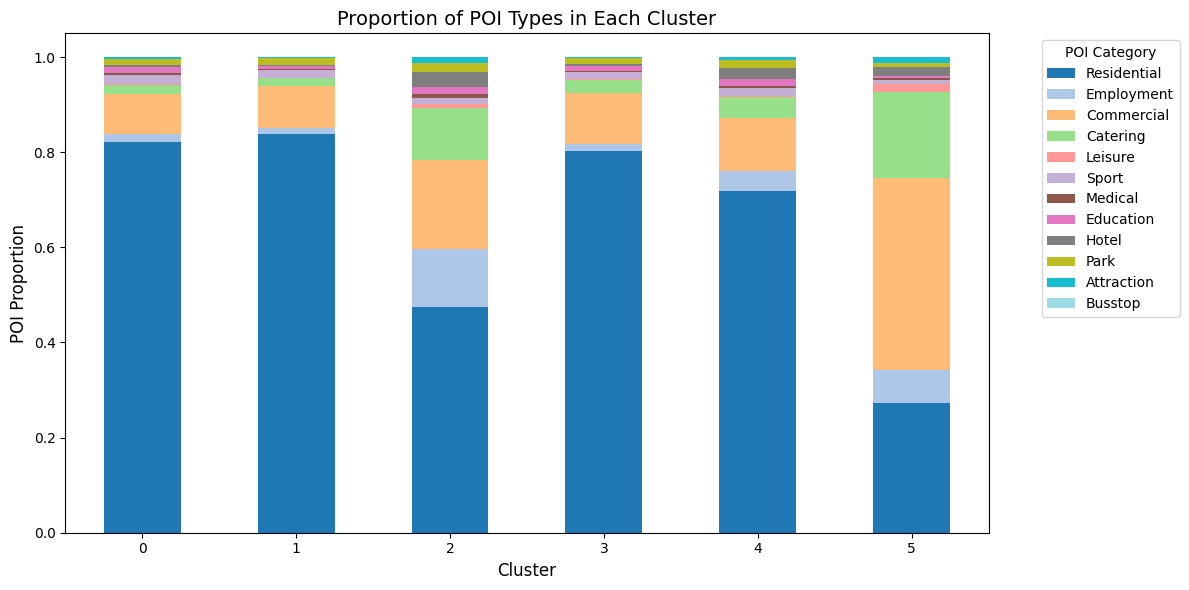

In [22]:
row_sums = cluster_poi_mean.sum(axis=1)

# 计算每类 POI 在每个聚类中的占比
df_percent = cluster_poi_mean.div(row_sums, axis=0)  # 行归一化

# 画堆叠柱状图（占比）
ax = df_percent.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')

# 美化图形
plt.title("Proportion of POI Types in Each Cluster", fontsize=14)
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("POI Proportion", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="POI Category")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [23]:
cluster_poi_summary

,Residential,Employment,Commercial,Catering,Leisure,Sport,Medical,Education,Hotel,Park,Attraction,Busstop
cluster_ratio,,,,,,,,,,,,
0,10590.0,225.0,1077.0,247.0,17.0,248.0,40.0,181.0,52.0,163.0,41.0,5.0
1,22024.0,359.0,2301.0,457.0,20.0,389.0,60.0,211.0,41.0,358.0,60.0,9.0
2,8836.0,2282.0,3490.0,2048.0,155.0,232.0,148.0,298.0,551.0,355.0,240.0,8.0
3,27695.0,547.0,3718.0,888.0,74.0,546.0,98.0,353.0,116.0,439.0,57.0,8.0
4,28168.0,1589.0,4432.0,1664.0,131.0,667.0,155.0,574.0,912.0,664.0,191.0,21.0
5,2894.0,729.0,4285.0,1915.0,181.0,87.0,44.0,56.0,192.0,87.0,140.0,0.0


anova analysis

In [29]:
variables = [
    "Residential", "Employment", "Commercial", "Catering", "Leisure",
    "Sport", "Medical", "Education", "Hotel", "Park", "Attraction", "Busstop"
]

anova_results = []

for var in variables:
    # 按聚类分组，取每组的变量值
    groups = [
        group[var].dropna().values
        for _, group in stations_with_poi.groupby("cluster_ratio")
    ]
    # 执行 ANOVA
    F, p = f_oneway(*groups)
    anova_results.append({
        "Variable": var,
        "F_statistic": F,
        "p_value": p
    })

# 转为表格
anova_df = pd.DataFrame(anova_results)
anova_df["significant_0.05"] = anova_df["p_value"] < 0.05
anova_df["significant_0.01"] = anova_df["p_value"] < 0.01

# 排序查看结果
anova_df = anova_df.sort_values(by="F_statistic", ascending=False)

In [25]:
anova_df

,Variable,F_statistic,p_value,significant_0.05,significant_0.01
1,Employment,67.218987,1.173561e-51,True,True
3,Catering,65.919778,7.137040e-51,True,True
4,Leisure,54.504384,1.097336e-43,True,True
2,Commercial,43.384261,4.103779e-36,True,True
10,Attraction,35.443613,2.609872e-30,True,True
7,Education,21.364798,4.411833e-19,True,True
6,Medical,18.998132,4.580612e-17,True,True
8,Hotel,17.089476,2.065351e-15,True,True
9,Park,10.990688,5.762737e-10,True,True
5,Sport,3.264796,6.634377e-03,True,True


In [27]:
from scipy.stats import pearsonr

correlation_results = []

for var in variables:
    corr, p = pearsonr(stations_with_poi[var], stations_with_poi["PC1"])
    correlation_results.append({
        "Variable": var,
        "Correlation_with_PC1": corr,
        "p_value": p
    })

correlation_df = pd.DataFrame(correlation_results)

correlation_df["significant_0.05"] = correlation_df["p_value"] < 0.05
correlation_df["significant_0.01"] = correlation_df["p_value"] < 0.01

correlation_df = correlation_df.sort_values(by="Correlation_with_PC1", ascending=False)


In [28]:
correlation_df

,Variable,Correlation_with_PC1,p_value,significant_0.05,significant_0.01
0,Residential,-0.001799,9.702987e-01,False,False
11,Busstop,-0.098545,4.086541e-02,True,False
5,Sport,-0.134528,5.150293e-03,True,True
9,Park,-0.283098,2.190301e-09,True,True
2,Commercial,-0.371241,1.568398e-15,True,True
8,Hotel,-0.384307,1.282659e-16,True,True
4,Leisure,-0.433717,3.397241e-21,True,True
6,Medical,-0.433851,3.293556e-21,True,True
7,Education,-0.436290,1.867942e-21,True,True
10,Attraction,-0.462370,3.238596e-24,True,True


看得出其实公交站和建筑数量影响并不是很明显，（可能保留公交站，然后下一步就是进行简单的多重线性回归）
第一步就是验证，变量之间的相关性和vif指数，这个验证完，就先做pc1的回归看看有没有效果，
假设检验还要做吗？


第二步再分别检验变量和pc1的空间相关性
1. 建立区域模型，根据分散区域的空间权重怎么计算
2. moranI
3. 滞后或者误差
4. 空间回归


1. 检查异常值

In [3]:
stations_with_poi = gpd.read_file('data/stations_with_poi.geojson')

In [4]:
categories = [
    "Residential", "Employment", "Commercial", "Catering", "Leisure", "Sport",
    "Medical", "Education", "Hotel", "Park", "Attraction", "Busstop"
]

In [6]:
stations_with_poi.shape

(431, 20)

In [7]:
X_vars = [
    "Employment", "Commercial", "Catering", "Leisure",
    "Sport", "Medical", "Education", "Hotel", "Park", "Attraction", "Busstop"
]
y_var = "PC1"

reg_df = stations_with_poi.copy()

In [8]:
def filter_outliers_multi(df, columns):
    df_filtered = df.copy()
    for col in columns:
        q1 = df_filtered[col].quantile(0.1)
        q3 = df_filtered[col].quantile(0.9)
        iqr = q3 - q1
        low = q1 - 3 * iqr
        high = q3 + 3 * iqr
        before = len(df_filtered)
        df_filtered = df_filtered[(df_filtered[col] >= low) & (df_filtered[col] <= high)]
        after = len(df_filtered)
        print(f"{col}: Dropped {before - after} observations")
    return df_filtered
# filter outliers from realhrwage

In [9]:
reg_df = filter_outliers_multi(reg_df, X_vars + [y_var])

Employment: Dropped 0 observations
Commercial: Dropped 5 observations
Catering: Dropped 1 observations
Leisure: Dropped 2 observations
Sport: Dropped 0 observations
Medical: Dropped 2 observations
Education: Dropped 0 observations
Hotel: Dropped 8 observations
Park: Dropped 1 observations
Attraction: Dropped 5 observations
Busstop: Dropped 0 observations
PC1: Dropped 0 observations


In [10]:
reg_df.shape

(407, 20)

2. 检查变量关系

Text(0.5, 1.0, 'Correlation Matrix')

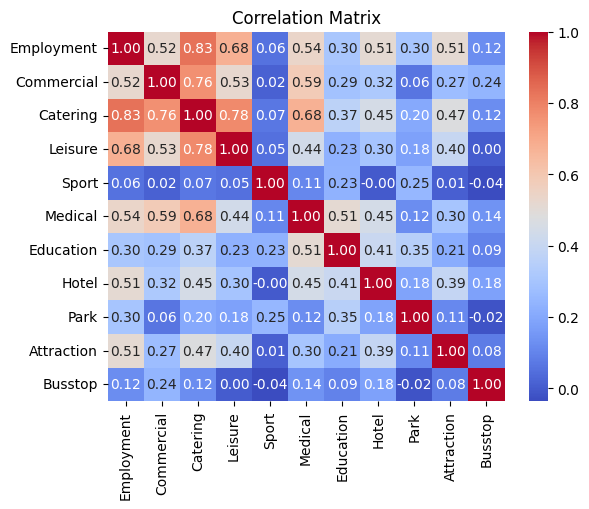

In [11]:
sns.heatmap(reg_df[X_vars].corr(), # plot a correlation matrix
            annot=True, # show the correlation values on the plot
            fmt=".2f", # set the format of the correlation values to be two decimal places
            cmap='coolwarm') # set the color palette to be coolwarm (blue for negative correlations, red for positive correlations)

plt.title('Correlation Matrix') # add a title

In [12]:
# calculating VIF
# This function is amended from: https://stackoverflow.com/a/51329496/4667568

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, list_var_not_to_remove=None, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param list_var_not_to_remove: the list of variables that should not be removed even though it has a high VIF. For example, dummy (or indicator) variables represent a categorical variable with three or more categories.
    :param thresh: the max VIF value before the feature is removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i)
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const as const should not be removed
        vif_df = vif_df.drop('const')

        # drop the variables that should not be removed
        if list_var_not_to_remove is not None:
            vif_df = vif_df.drop(list_var_not_to_remove)

        print('Max VIF:', vif_df.VIF.max())

        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [13]:
X_filtered = drop_column_using_vif_(reg_df[X_vars], list_var_not_to_remove=None, thresh=5)

Max VIF: 9.748932818277446
Dropping: Catering
Max VIF: 2.8647918833751085


In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd

# 你的原始自变量数据（只选数值列）
X_raw = reg_df[X_vars]

# 加常数项
X_raw_const = add_constant(X_raw)

# 计算 VIF
vif_raw = pd.Series(
    [variance_inflation_factor(X_raw_const.values, i) for i in range(X_raw_const.shape[1])],
    index=X_raw_const.columns,
    name="VIF_raw"
).to_frame()

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X_raw)
X_scaled = pd.DataFrame(X_scaled_array, columns=X_raw.columns)

# 加常数项再计算 VIF
X_scaled_const = add_constant(X_scaled)

vif_scaled = pd.Series(
    [variance_inflation_factor(X_scaled_const.values, i) for i in range(X_scaled_const.shape[1])],
    index=X_scaled_const.columns,
    name="VIF_scaled"
).to_frame()
vif_comparison = pd.concat([vif_raw, vif_scaled], axis=1)
print(vif_comparison)


             VIF_raw  VIF_scaled
const       3.875734    1.000000
Employment  4.348402    4.348402
Commercial  2.985173    2.985173
Catering    9.748933    9.748933
Leisure     2.786586    2.786586
Sport       1.115339    1.115339
Medical     2.351105    2.351105
Education   1.673855    1.673855
Hotel       1.620322    1.620322
Park        1.316781    1.316781
Attraction  1.437671    1.437671
Busstop     1.121470    1.121470


Text(0.5, 1.0, 'Correlation Matrix')

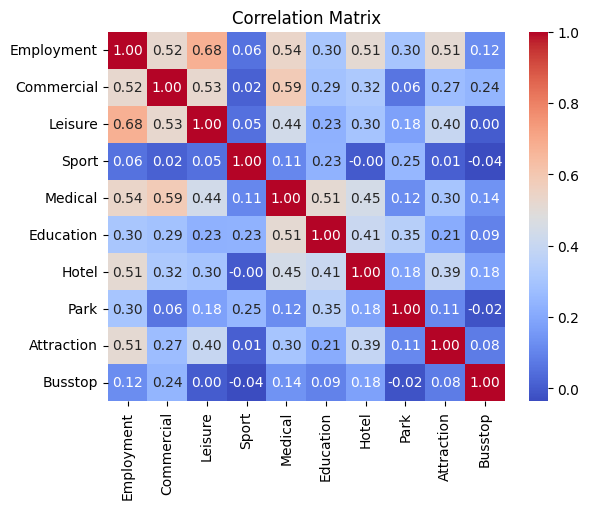

In [15]:
sns.heatmap(X_filtered.corr(), # plot a correlation matrix
            annot=True, # show the correlation values on the plot
            fmt=".2f", # set the format of the correlation values to be two decimal places
            cmap='coolwarm') # set the color palette to be coolwarm (blue for negative correlations, red for positive correlations)

plt.title('Correlation Matrix') # add a title

In [16]:
X_filtered.shape

(407, 10)

In [17]:
import statsmodels.api as sm
X = sm.add_constant(X_filtered) 
y = reg_df[y_var]
ols_model = sm.OLS(y, X).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    PC1   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     43.66
Date:                Wed, 02 Jul 2025   Prob (F-statistic):           6.49e-58
Time:                        17:21:32   Log-Likelihood:                 496.44
No. Observations:                 407   AIC:                            -970.9
Df Residuals:                     396   BIC:                            -926.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0967      0.007     13.810      0.0

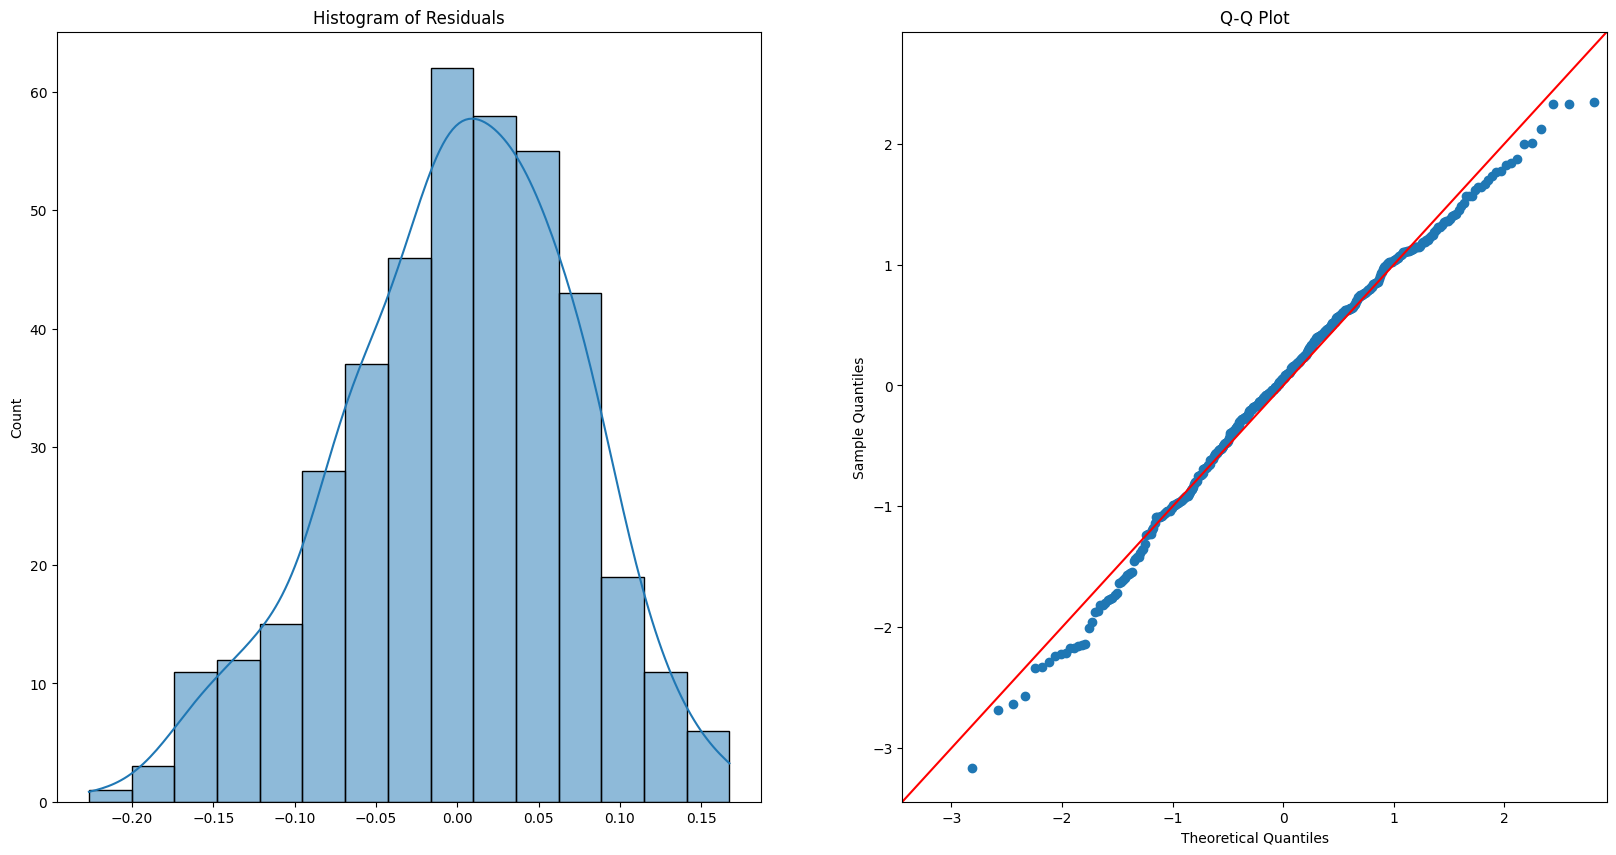

In [18]:
residuals = ols_model.resid # get the residuals

# make the figure wider
plt.rcParams["figure.figsize"] = [20, 10]

f, axes = plt.subplots(1, 2)
sns.histplot(residuals, kde=True, ax=axes[0]) # plot the residuals
axes[0].set_title('Histogram of Residuals') # add a title

sm.qqplot(residuals, line='45', fit=True,  ax=axes[1]) # plot the residuals
axes[1].set_title('Q-Q Plot') # add a title

plt.show() # show the plot

第一步：GWR 分析主成分（PC1）
目的：揭示结构性变量对空间行为结构的局部作用机制

用 GWR 替代 OLS 分析 PC1 ~ POI 之间的关系

可视化每个变量的局部回归系数地图

重点说明哪些结构变量在不同位置表现出不同强度（如就业在中心更显著）

🧩 关键图表：变量系数地图 + 局部R²地图

第二步：按 Borough 聚合分析差异
目的：识别空间聚类结构在行政区层级上的系统性分布

计算各 Borough 中 PC1 或聚类类别的均值

对比不同 Borough 中 POI 分布、聚类比例、PC1 平均值

可视化 boxplot / bar chart / 聚类分布地图

🧩 关键图表：borough boxplot（PC1 或群组）、聚类类型在 borough 分布的地图

第三步：引入真实进出站流量做补充分析
目的：验证结构变量是否也能解释实际强度层面

可选方法：

对具体时间段流量建 OLS 回归（如早高峰进站量）

或者对 PC1 与流量做相关性分析，解释行为结构是否等价于“强度高”

如你想探索机制链条：POI → PC1 → 流量，可做路径分析（如 SEM）

🧩 关键图表：回归表格 + 结构 vs 强度相关图

GWR， spatial weight matrix

In [19]:
import numpy as np
from sklearn.model_selection import KFold
from mgwr.gwr import GWR
from sklearn.metrics import pairwise_distances
from libpysal.weights.util import full2W
from esda.moran import Moran
from libpysal.weights import DistanceBand
from esda.moran import Moran
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from mgwr.gwr import GWR
from sklearn.cluster import KMeans
import libpysal

In [ ]:
# 1. 读取并设定坐标系
#buffers = gpd.read_file("data/stations_tfl.geojson")

# 3. 提取质心坐标（现在是米）
#buffers["centroid"] = buffers.geometry.centroid
#buffers["x"] = buffers.centroid.x
#buffers["y"] = buffers.centroid.y

# 4. 获取坐标数组用于距离计算
#coords = buffers[["x", "y"]].values


In [20]:
# 1. 读取并设定坐标系
buffers = reg_df.copy()
buffers = buffers.set_crs(epsg=4326)

# 2. 投影到米制（EPSG:27700）
buffers = buffers.to_crs(epsg=27700)

# 3. 提取质心坐标（现在是米）
buffers["centroid"] = buffers.geometry.centroid
buffers["x"] = buffers.centroid.x
buffers["y"] = buffers.centroid.y

# 4. 获取坐标数组用于距离计算
coords = buffers[["x", "y"]].values

In [21]:
print(buffers[["x", "y"]].isna().sum())     # 是否有 NaN 坐标
print(buffers.geometry.is_empty.sum())     # 是否有空几何
print(buffers.geometry.is_valid.sum())     # 是否所有几何有效

x    0
y    0
dtype: int64
0
407


In [22]:
from sklearn.metrics import pairwise_distances
import numpy as np
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW

d = pairwise_distances(coords)
print("平均距离:", d.mean(), "最大:", d.max(), "最小（非对角）:", d[d > 0].min())

平均距离: 16182.072730826145 最大: 92294.26737826508 最小（非对角）: 13.152946437965905


In [23]:
# 将 coords 中的重复坐标行标识出来
coords_df = pd.DataFrame(coords, columns=['x', 'y'], index=buffers.index) 
duplicate_mask = coords_df.duplicated(keep=False)

# 将重复标识传回 buffers，提取对应行
buffers_with_coords = buffers.copy()
buffers_with_coords["x"] = coords_df["x"]
buffers_with_coords["y"] = coords_df["y"]

duplicate_buffers = buffers_with_coords[duplicate_mask]

# 按坐标排序
duplicate_buffers = duplicate_buffers.sort_values(by=["x", "y"]).reset_index()

# 显示重复数和相关字段
print(f"重复坐标总数（含组内所有点）：{duplicate_buffers.shape[0]}")
print(duplicate_buffers[["index", "x", "y", "NLC", "NAME"]])


重复坐标总数（含组内所有点）：8
   index              x              y   NLC                         NAME
0    269  505109.000866  175923.999502   783       Heathrow Terminal 5 LU
1    430  505109.000866  175923.999502  9846       Heathrow Terminal 5 EL
2    267  507586.000868  175839.999503   780    Heathrow Terminals 123 LU
3    417  507586.000868  175839.999503  7090  Heathrow Terminals 2 & 3 EL
4    268  508082.000868  174429.999502   781       Heathrow Terminal 4 LU
5    418  508082.000868  174429.999502  7091       Heathrow Terminal 4 EL
6    133  533094.000883  181566.999512   634          Liverpool Street LU
7    407  533094.000883  181566.999512  6965          Liverpool Street NR


In [24]:
coords_perturbed = coords.copy()
perturbation = np.random.normal(scale=0.001, size=coords[duplicate_mask].shape)  # 单位是米，0.001 ≈ 1mm
coords_perturbed[duplicate_mask] += perturbation

In [25]:
original_duplicates = coords_df[duplicate_mask].copy()
perturbed_duplicates = pd.DataFrame(coords_perturbed[duplicate_mask], columns=['x_perturbed', 'y_perturbed'], index=original_duplicates.index)

# 合并前后对比
comparison_df = pd.concat([original_duplicates, perturbed_duplicates], axis=1)

# 可选：添加 NAME、NLC 信息
comparison_df["NLC"] = buffers.loc[comparison_df.index, "NLC"].values
comparison_df["NAME"] = buffers.loc[comparison_df.index, "NAME"].values

# 按照原始坐标排序以便成对查看
comparison_df = comparison_df.sort_values(by=["x", "y"])

# 输出结果
pd.set_option("display.precision", 10)
print(comparison_df[["x", "y", "x_perturbed", "y_perturbed", "NLC", "NAME"]])

                     x                  y        x_perturbed  \
269  505109.0008664608  175923.9995021839  505109.0003001521   
430  505109.0008664608  175923.9995021839  505108.9991136324   
267  507586.0008678217  175839.9995025742  507585.9995047153   
417  507586.0008678217  175839.9995025742  507586.0008553962   
268  508082.0008678331  174429.9995015908  508082.0033485211   
418  508082.0008678331  174429.9995015908  508082.0005568651   
133  533094.0008826840  181566.9995116470  533094.0012223887   
407  533094.0008826840  181566.9995116470  533094.0026145395   

           y_perturbed   NLC                         NAME  
269  175923.9985924673   783       Heathrow Terminal 5 LU  
430  175923.9984136450  9846       Heathrow Terminal 5 EL  
267  175839.9995410329   780    Heathrow Terminals 123 LU  
417  175840.0008192040  7090  Heathrow Terminals 2 & 3 EL  
268  174429.9995146815   781       Heathrow Terminal 4 LU  
418  174429.9991550509  7091       Heathrow Terminal 4 EL  
133

In [26]:
X_vars = [
    "Employment", "Commercial", "Leisure",
    "Sport", "Medical", "Education", "Hotel", "Park", "Attraction", "Busstop"
]
y_var = "PC1"

In [27]:
X = buffers[X_vars].values  # m 个变量
X = np.hstack([np.ones((X.shape[0], 1)), X])
y = buffers[y_var].values.reshape(-1, 1)

In [28]:
coords_df = pd.DataFrame(coords, columns=['x', 'y'], index=buffers.index)
duplicate_mask = coords_df.duplicated(keep=False).values  # 转成 np.bool_ array，确保 shape 一致
coords_perturbed = coords.copy()
coords_perturbed[duplicate_mask] += np.random.normal(scale=0.001, size=coords_perturbed[duplicate_mask].shape)

# 然后传入 DistanceBand
w = DistanceBand(coords_perturbed, threshold=2000, binary=False, silence_warnings=True)
w.transform = 'R'

d:\Uss\Dissertation\coding\pam311_env\Lib\site-packages\scipy\sparse\_data.py:128: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)


改了重复坐标但是还是没能去掉不知道为什么?? !!! 待会儿再看看吧

Euclidean distance

In [29]:
# 计算 X 中每个变量的 Moran's I（跳过截距项）
moran_results = []
for i, var in enumerate(X_vars):
    xi = X[:, i + 1 ]   # 跳过截距项 X[:, 0]
    mi = Moran(xi, w)
    moran_results.append({'Variable': var, 'Moran_I': mi.I, 'p_value': mi.p_sim})

# 计算 y 的 Moran's I
mi_y = Moran(y.flatten(), w)
moran_results.append({'Variable': 'y', 'Moran_I': mi_y.I, 'p_value': mi_y.p_sim})

# 整理输出结果
moran_df = pd.DataFrame(moran_results).sort_values(by='Moran_I', ascending=False)
print(moran_df.round(4).to_string(index=False))

  Variable  Moran_I  p_value
Employment   0.7504    0.001
         y   0.7252    0.001
     Hotel   0.6703    0.001
   Leisure   0.6218    0.001
Attraction   0.5704    0.001
      Park   0.5349    0.001
 Education   0.4945    0.001
   Medical   0.4425    0.001
Commercial   0.3970    0.001
   Busstop   0.2611    0.001
     Sport   0.2173    0.001


In [30]:
for th in [300, 500, 1000, 1500, 2000]:
    w = DistanceBand(coords_perturbed, threshold=th, binary=False, silence_warnings=True)
    w.transform = 'R'
    neighbor_counts = np.array([len(w.neighbors[i]) for i in range(len(coords))])
    print(f"Threshold = {th}m → min: {neighbor_counts.min()}, mean: {neighbor_counts.mean():.1f}, max: {neighbor_counts.max()}")

Threshold = 300m → min: 0, mean: 0.1, max: 4
Threshold = 500m → min: 0, mean: 0.3, max: 6
Threshold = 1000m → min: 0, mean: 1.8, max: 10
Threshold = 1500m → min: 0, mean: 4.2, max: 14
Threshold = 2000m → min: 0, mean: 7.1, max: 22


d:\Uss\Dissertation\coding\pam311_env\Lib\site-packages\scipy\sparse\_data.py:128: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)


In [31]:
# 步骤 1：选择最优带宽（默认使用 CV 最小化）AICc（Corrected Akaike Information Criterion）
selector = Sel_BW(coords_perturbed, y, X, kernel='exponential', fixed=True) #gaussian，“实际距离”衡量
opt_bw = selector.search()
print(f"最优带宽为：{opt_bw}")

最优带宽为：4452.02


In [32]:
# Step 2：统计每个观测点的“有效邻居数”（权重大于阈值，比如 1e-6）
model = GWR(coords_perturbed, y, X, bw=opt_bw, kernel='exponential', fixed=True)
results = model.fit()
neighbor_counts = [np.sum(w_row > 1e-6) for w_row in results.W]
avg_neighbors = np.mean(neighbor_counts)

print(f"Average effective number of neighbors (weights > 1e-6)：{avg_neighbors:.1f}")

Average effective number of neighbors (weights > 1e-6)：405.7


In [33]:
assert X.shape[0] == y.shape[0] == coords_perturbed.shape[0]

In [34]:
#两种kernel的对比
for k in ['gaussian', 'exponential']:
    bw = Sel_BW(coords, y, X, kernel=k, fixed=True).search()
    model = GWR(coords, y, X, bw=bw, kernel=k, fixed=True).fit()
    print(f"Kernel: {k}, BW: {bw}, R2: {model.R2:.4f}")


Kernel: gaussian, BW: 4718.7, R2: 0.7399
Kernel: exponential, BW: 4452.02, R2: 0.7383


In [35]:
def spatial_kfold_gwr_cv(coords, X, y, bw_list, k=5, alpha=0.5, verbose=True):
    n = len(y)
    labels = KMeans(n_clusters=k, random_state=42).fit(coords).labels_
    scores = []

    for bw in bw_list:
        fold_errors, fold_neighbors = [], []
        for fold in range(k):
            test_idx = (labels == fold)
            train_idx = ~test_idx
            gwr = GWR(coords[train_idx], y[train_idx], X[train_idx], bw=bw, kernel='exponential', fixed=True)
            res = gwr.fit()

            preds = []
            for i, coord in enumerate(coords[test_idx]):
                dists = np.linalg.norm(coords[train_idx] - coord, axis=1)
                weights = np.exp(-dists / bw)
                weights = weights / weights.sum() if weights.sum() > 0 else weights
                beta = np.average(res.params, axis=0, weights=weights)
                preds.append(np.dot(X[test_idx][i], beta))

            preds = np.array(preds)
            mask = ~np.isnan(preds)
            if np.any(mask):
                err = mean_absolute_error(y[test_idx][mask], preds[mask])
                fold_errors.append(err)
                fold_neighbors.append(np.mean([np.sum(w > 1e-6) for w in res.W]))

        err_mean = np.nanmean(fold_errors)
        neigh_mean = np.nanmean(fold_neighbors)
        score = err_mean + alpha * (neigh_mean / n)
        scores.append({'bw': bw, 'MAE': err_mean, 'Neighbors': neigh_mean, 'Score': score})

        if verbose:
            print(f"bw={bw} → MAE={err_mean:.4f}, Neighbors={neigh_mean:.1f}, Score={score:.4f}")

    result_df = pd.DataFrame(scores)
    best_row = result_df.loc[result_df['Score'].idxmin()]
    return best_row['bw'], result_df.sort_values(by='Score')

In [36]:
bw_list = [1500, 2000, 3000, 4000, 4500, 5000]
best_bw, result_df = spatial_kfold_gwr_cv(coords, X, y, bw_list, alpha= 0.5)

bw=1500 → MAE=0.0785, Neighbors=242.7, Score=0.3766
bw=2000 → MAE=0.0749, Neighbors=284.9, Score=0.4249
bw=3000 → MAE=0.0705, Neighbors=316.7, Score=0.4596
bw=4000 → MAE=0.0685, Neighbors=323.5, Score=0.4660
bw=4500 → MAE=0.0681, Neighbors=324.6, Score=0.4669
bw=5000 → MAE=0.0678, Neighbors=325.3, Score=0.4674


In [37]:
def loocv_gwr_bw(coords, X, y, bw_list): #loocv 逐点剔除交叉验证
    scores = []
    n = len(y)

    for bw in bw_list:
        preds = []
        for i in range(n):
            train_idx = np.arange(n) != i
            test_coord = coords[i:i+1]
            gwr = GWR(coords[train_idx], y[train_idx], X[train_idx], bw=bw, fixed=True, kernel='exponential')
            res = gwr.fit()
            dists = np.linalg.norm(coords[train_idx] - test_coord, axis=1)
            weights = np.exp(-dists / bw)
            weights = weights / weights.sum() if weights.sum() > 0 else weights
            beta = np.average(res.params, axis=0, weights=weights)
            y_pred = np.dot(X[i], beta)
            preds.append(y_pred)
        
        mae = mean_absolute_error(y, preds)
        scores.append({'bw': bw, 'MAE': mae})
        print(f"bw={bw} → MAE={mae:.4f}")
    
    result_df = pd.DataFrame(scores)
    best_bw = result_df.loc[result_df['MAE'].idxmin(), 'bw']
    return best_bw, result_df

In [38]:
bw_list = [1500, 2000, 3000, 4000,4500, 5000]
best_bw, result_df = loocv_gwr_bw(coords, X, y, bw_list)

bw=1500 → MAE=0.0517
bw=2000 → MAE=0.0511
bw=3000 → MAE=0.0530
bw=4000 → MAE=0.0551
bw=4500 → MAE=0.0559
bw=5000 → MAE=0.0565


In [41]:
gwr_model_1 = GWR(coords_perturbed, y, X, bw=2000, kernel='exponential', fixed=True)
gwr_results_1 = gwr_model_1.fit()

In [42]:
print(gwr_results_1.R2)
print(gwr_results_1.adj_R2)

0.8799020114181556
0.7837266642858861


In [43]:
gwr_model_2 = GWR(coords_perturbed, y, X, bw=4452, kernel='exponential', fixed=True)
gwr_results_2 = gwr_model_2.fit()

In [44]:
print(gwr_results_2.R2)
print(gwr_results_2.adj_R2)

0.7382730990498052
0.680779314921044


In [95]:
from esda.moran import Moran
np.random.seed(42)
w1 = DistanceBand(coords_perturbed, threshold=2000, binary=False, silence_warnings=True)
w1.transform = 'R'
mi_resid_1 = Moran(gwr_results_1.resid_response, w1, permutations=999)
print(f"Residual Moran’s I = {mi_resid_1.I:.4f}, p = {mi_resid_1.p_sim:.4f}")

Residual Moran’s I = -0.0667, p = 0.0480


In [ ]:
from esda.moran import Moran
np.random.seed(42)
w2 = DistanceBand(coords_perturbed, threshold=4452, binary=False, silence_warnings=True)
w2.transform = 'R'
mi_resid_2 = Moran(gwr_results_2.resid_response, w2 , permutations=999)
print(f"Residual Moran’s I = {mi_resid_2.I:.4f}, p = {mi_resid_2.p_sim:.4f}")

Residual Moran’s I = 0.0728, p = 0.0030


In [97]:
np.random.seed(42)
threshold = 5000  # 米，调整直到邻居数量合理且无孤岛
w = libpysal.weights.DistanceBand(coords, threshold=threshold, binary=True)
mi = Moran(gwr_results_2.resid_response, w , permutations=999)

print(f"Moran's I: {mi.I}")
print(f"p-value: {mi.p_sim}")

('WARNING: ', 322, ' is an island (no neighbors)')
('WARNING: ', 324, ' is an island (no neighbors)')
Moran's I: 0.061425946585591445
p-value: 0.001


In [48]:
from mgwr.gwr import GWR

model = GWR(coords_perturbed, y, X, bw=2000, kernel='exponential', fixed=True)
results = model.fit()

In [49]:
# 第 k 个变量（例如：房价）在每个点的局部回归系数
# 注意：params 是 n × p 的矩阵（n 个位置，p 个变量，含截距）
k = 1  # 比如第 2 个变量（索引从 0 开始，第一个是截距）
local_coeffs = results.params[:, k]
local_std_errs = results.bse[:, k]

# 显著性检验：绝对值 > 2 * 标准误，表示显著
sig_mask = np.abs(local_coeffs) > 2 * local_std_errs

# 如果你想将显著性结果保存到 DataFrame 里
import pandas as pd
df_result = pd.DataFrame({
    'coef': local_coeffs,
    'se': local_std_errs,
    'sig': sig_mask  # True 表示显著
})

In [50]:
df_result['sig'].value_counts()

sig
False    218
True     189
Name: count, dtype: int64

In [51]:
params = results.params   # shape: (n_locations, n_variables + 1), 含截距
bse = results.bse         # shape: 同上

summary = []

for i, var in enumerate(X_vars, start=1):  # 从1开始跳过截距
    coef = params[:, i]
    se = bse[:, i]
    sig = abs(coef) > 2 * se
    sig_counts = pd.Series(sig).value_counts().to_dict()
    summary.append({
        "Variable": var,
        "Significant (True)": sig_counts.get(True, 0),
        "Not Significant (False)": sig_counts.get(False, 0),
        "Total": len(sig)
    })

summary_df = pd.DataFrame(summary)
print(summary_df)

     Variable  Significant (True)  Not Significant (False)  Total
0  Employment                 189                      218    407
1  Commercial                  86                      321    407
2     Leisure                  80                      327    407
3       Sport                  15                      392    407
4     Medical                  39                      368    407
5   Education                 187                      220    407
6       Hotel                 293                      114    407
7        Park                 159                      248    407
8  Attraction                 224                      183    407
9     Busstop                 107                      300    407


In [52]:
# 设置显著阈值比例
threshold = 0.5
total_points = summary_df["Total"].iloc[0]  # 应该都一样，取第一个

# 找出显著点占比超过阈值的变量
summary_df["Significant Ratio"] = summary_df["Significant (True)"] / total_points
significant_vars = summary_df[summary_df["Significant Ratio"] > threshold]

print("显著变量有：")
print(significant_vars[["Variable", "Significant (True)", "Total", "Significant Ratio"]])

显著变量有：
     Variable  Significant (True)  Total  Significant Ratio
6       Hotel                 293    407       0.7199017199
8  Attraction                 224    407       0.5503685504


In [53]:
residuals = y.flatten() - results.predy.flatten()

In [54]:
from libpysal.weights import DistanceBand
import numpy as np

w_4000 = DistanceBand(coords_perturbed, threshold=4500, binary=True, silence_warnings=True)
neighbor_counts = np.array([len(w_4000.neighbors[i]) for i in range(len(coords))])
print("最小邻居数:", neighbor_counts.min())
print("平均邻居数:", neighbor_counts.mean())
print("最大邻居数:", neighbor_counts.max())
print("没有邻居的点数量:", np.sum(neighbor_counts == 0))


最小邻居数: 0
平均邻居数: 33.01719901719902
最大邻居数: 73
没有邻居的点数量: 2


In [55]:
print(results.summary())
print("GWR 全局 R²:", results.R2)
print("GWR 调整后 R²:", results.adj_R2)

Model type                                                         Gaussian
Number of observations:                                                 407
Number of covariates:                                                    11

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                              2.078
Log-likelihood:                                                     496.444
AIC:                                                               -970.889
AICc:                                                              -968.097
BIC:                                                              -2377.412
R2:                                                                   0.524
Adj. R2:                                                              0.512

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [56]:
import statsmodels.api as sm
X = sm.add_constant(X_filtered) 
y = reg_df[y_var]
ols_model = sm.OLS(y, X).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    PC1   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     43.66
Date:                Wed, 02 Jul 2025   Prob (F-statistic):           6.49e-58
Time:                        17:44:43   Log-Likelihood:                 496.44
No. Observations:                 407   AIC:                            -970.9
Df Residuals:                     396   BIC:                            -926.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0967      0.007     13.810      0.0

In [57]:

comparison = pd.DataFrame({
    'Model': ['MLR (OLS)', 'GWR'],
    'R²': [ols_model.rsquared, results.R2],
    'Adj. R²': [ols_model.rsquared_adj, results.adj_R2],
    'AIC / AICc': [ols_model.aic, results.aicc]
})

print(comparison)

       Model            R²       Adj. R²      AIC / AICc
0  MLR (OLS)  0.5243804098  0.5123698141 -970.8885133520
1        GWR  0.8799020114  0.7837266643 -894.6589293445


In [58]:
params = results.params  # shape: (n_samples, n_vars+1)

for i, var in enumerate(X_vars, start=1):  # 跳过截距项
    buffers[f'coef_{var}'] = params[:, i]

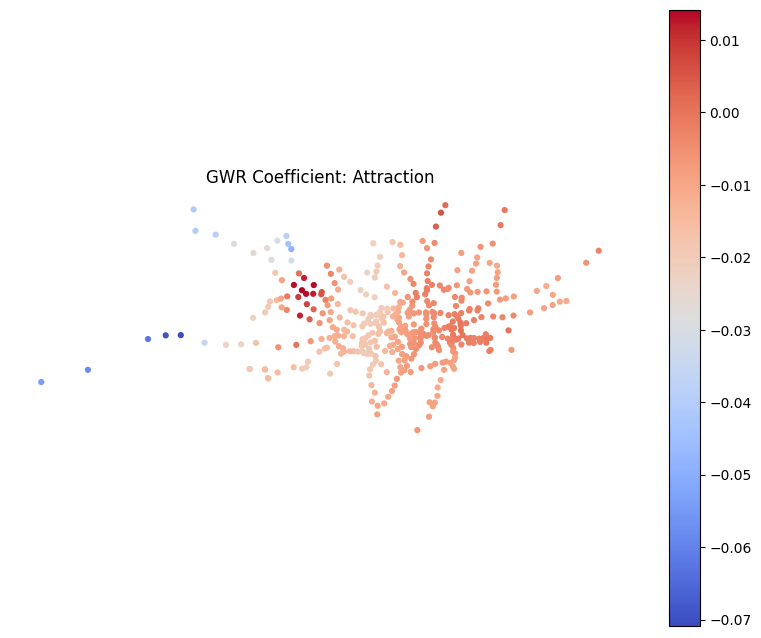

In [61]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
buffers.plot(column='coef_Attraction', cmap='coolwarm', legend=True, ax=ax)
ax.set_title('GWR Coefficient: Attraction')
ax.axis('off')
plt.show()

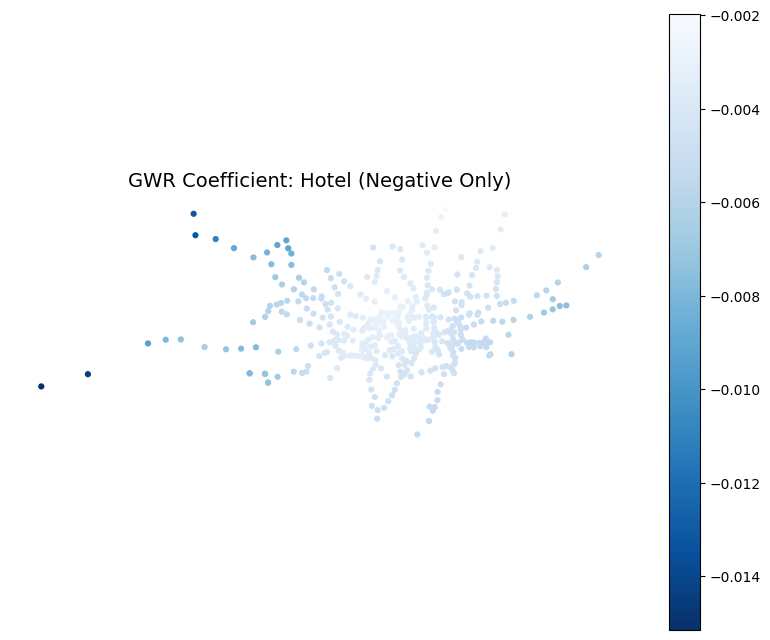

In [148]:
vmin = buffers['coef_Hotel'].min()
vmax = buffers['coef_Hotel'].max()

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

buffers.plot(
    column='coef_Hotel',
    cmap='Blues_r',      # ✅ 改为单调色图
    vmin=vmin,
    vmax=vmax,
    legend=True,
    ax=ax
)

ax.set_title('GWR Coefficient: Hotel (Negative Only)', fontsize=14)
ax.axis('off')

plt.show()


KNN。

In [63]:
from libpysal.weights import KNN

# 假设 coords 是 (n_stations, 2) 的 NumPy 数组（米制坐标）
w_knn = KNN(coords_perturbed, k=5)  # 每个站点连接到最近的 5 个站点
w_knn.transform = 'R'     # 可选：行标准化（GWR 更推荐）

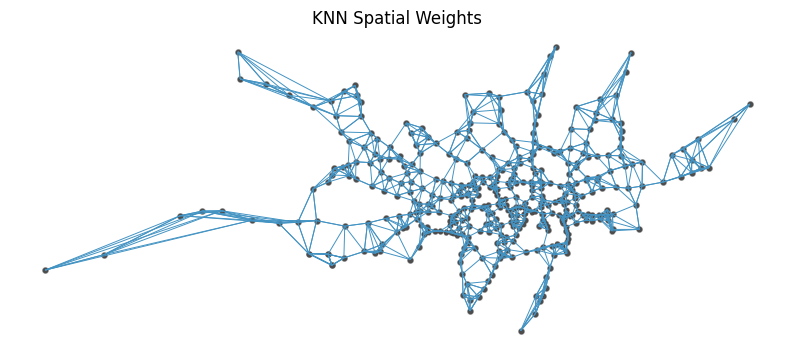

In [64]:
from splot.libpysal import plot_spatial_weights
gdf = buffers.copy()
gdf["geometry"] = gdf.centroid  # 用质心画图

# 创建图和坐标轴
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# 使用质心 geometry 绘制底图
gdf_centroids = buffers.copy()
gdf_centroids["geometry"] = gdf_centroids.centroid
gdf_centroids.plot(ax=ax, color='lightblue', markersize=10)

# 绘制空间权重线（KNN）
plot_spatial_weights(w_knn, gdf_centroids, ax=ax)

ax.set_title("KNN Spatial Weights")
plt.show()

In [65]:
# Moran I
mi_knn = Moran(y, w_knn)
print(f"Moran's I (KNN) = {mi_knn.I:.4f}, p = {mi_knn.p_sim:.4f}")

Moran's I (KNN) = 0.6960, p = 0.0010


In [66]:
X = buffers[X_vars].values  # m 个变量
X = np.hstack([np.ones((X.shape[0], 1)), X])
y = buffers[y_var].values.reshape(-1, 1)

In [67]:
moran_results = []
for i, var in enumerate(X_vars):
    xi = X[:, i + 1]  # 跳过截距项 X[:, 0]
    mi = Moran(xi, w_knn)
    moran_results.append({'Variable': var, 'Moran_I': mi.I, 'p_value': mi.p_sim})

# 计算 y 的 Moran's I
mi_y = Moran(y.flatten(), w_knn)
moran_results.append({'Variable': 'y', 'Moran_I': mi_y.I, 'p_value': mi_y.p_sim})

# 整理输出结果
moran_df = pd.DataFrame(moran_results).sort_values(by='Moran_I', ascending=False)
print(moran_df.round(4).to_string(index=False))

  Variable  Moran_I  p_value
Employment   0.7656    0.001
         y   0.6960    0.001
     Hotel   0.6793    0.001
   Leisure   0.6138    0.001
Attraction   0.5646    0.001
      Park   0.5527    0.001
 Education   0.5236    0.001
   Medical   0.4519    0.001
Commercial   0.3263    0.001
     Sport   0.2165    0.001
   Busstop   0.1223    0.001


In [68]:
X_vars = [var for var in X_vars if var != 'Busstop']
X = buffers[X_vars].values
X = np.hstack([np.ones((X.shape[0], 1)), X])

In [69]:
df = buffers[X_vars].copy()
print(df.nunique())

Employment     65
Commercial    121
Leisure        12
Sport          26
Medical        12
Education      18
Hotel          24
Park           21
Attraction     14
dtype: int64


In [70]:
#AICC
# 构建数据（X: 自变量，y: 因变量，coords: 空间点）
bw = Sel_BW(coords_perturbed, y, X, fixed=False, kernel='bisquare', spherical=False).search(bw_min=2)
print(f"Selected bandwidth (nearest neighbors count): {bw}")


Selected bandwidth (nearest neighbors count): 116.0


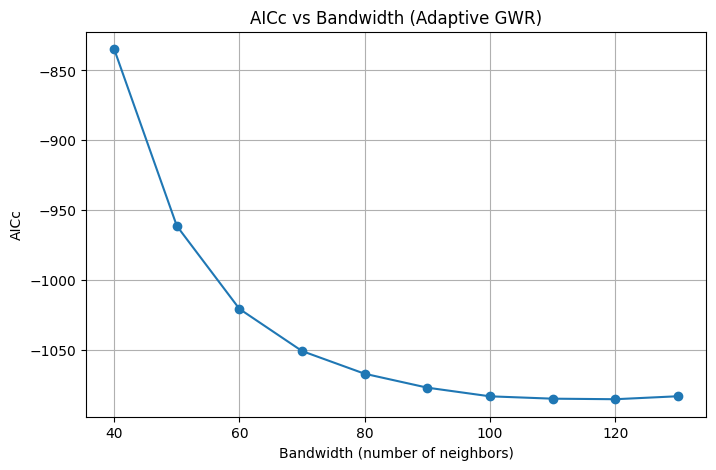

In [71]:
bandwidths = list(range(40, 131, 10))  # 比如从40到130，每10一个

aicc_list = []

for bw in bandwidths:
    model = GWR(coords_perturbed, y, X, bw=bw, fixed=False, kernel='bisquare')
    results = model.fit()
    aicc_list.append(results.aicc)

# 画出 bandwidth 与 AICc 的关系
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(bandwidths, aicc_list, marker='o')
plt.xlabel('Bandwidth (number of neighbors)')
plt.ylabel('AICc')
plt.title('AICc vs Bandwidth (Adaptive GWR)')
plt.grid(True)
plt.show()

In [ ]:
gwr_model = GWR(coords_perturbed, y, X, bw=bw, fixed=False, kernel='bisquare', spherical=False)
gwr_results = gwr_model.fit()

print(gwr_results.summary())

Model type                                                         Gaussian
Number of observations:                                                 407
Number of covariates:                                                    10

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                              2.081
Log-likelihood:                                                     496.141
AIC:                                                               -972.281
AICc:                                                              -969.613
BIC:                                                              -2383.418
R2:                                                                   0.524
Adj. R2:                                                              0.513

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [73]:
print("GWR 全局 R²:", gwr_results.R2)
print("GWR 调整后 R²:", gwr_results.adj_R2)

GWR 全局 R²: 0.7397209806157647
GWR 调整后 R²: 0.6911333203388669


In [74]:
np.random.seed(42)
w_knn_2 = KNN(coords_perturbed, k=116)
w_knn_2 .transform = 'R' 
mi_resid_knn = Moran(gwr_results.resid_response, w_knn_2 , permutations=999)
print(f"Residual Moran’s I = {mi_resid_knn.I:.4f}, p = {mi_resid_knn.p_sim:.4f}")

Residual Moran’s I = 0.0016, p = 0.1800


In [154]:
np.random.seed(42)
threshold = 5000  # 米，调整直到邻居数量合理且无孤岛
w = libpysal.weights.DistanceBand(coords, threshold=threshold, binary=True)
mi = Moran(gwr_results.resid_response, w , permutations=999)

print(f"Moran's I: {mi.I}")
print(f"p-value: {mi.p_sim}")

('WARNING: ', 322, ' is an island (no neighbors)')
('WARNING: ', 324, ' is an island (no neighbors)')
Moran's I: 0.022195319835947448
p-value: 0.086


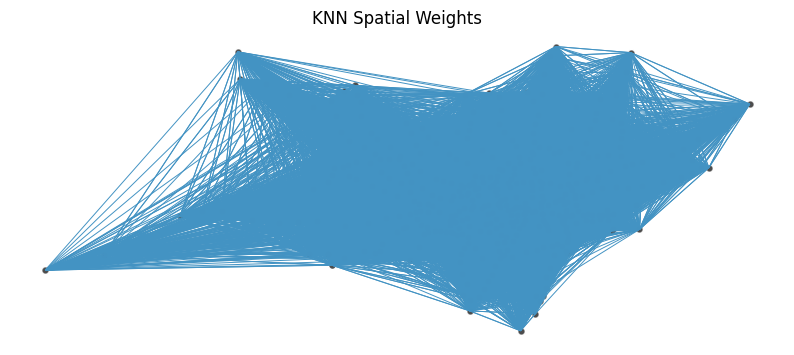

In [204]:
from splot.libpysal import plot_spatial_weights
gdf = buffers.copy()
gdf["geometry"] = gdf.centroid  # 用质心画图

# 创建图和坐标轴
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# 使用质心 geometry 绘制底图
gdf_centroids = buffers.copy()
gdf_centroids["geometry"] = gdf_centroids.centroid
gdf_centroids.plot(ax=ax, color='lightblue', markersize=1)

# 绘制空间权重线（KNN）
plot_spatial_weights(w_knn_2, gdf_centroids, ax=ax)

ax.set_title("KNN Spatial Weights")
plt.show()

In [98]:
params = gwr_results.params   # shape: (n_locations, n_variables + 1), 含截距
bse = gwr_results.bse         # shape: 同上

summary = []

for i, var in enumerate(X_vars, start=1):  # 从1开始跳过截距
    coef = params[:, i]
    se = bse[:, i]
    sig = abs(coef) > 2 * se
    sig_counts = pd.Series(sig).value_counts().to_dict()
    summary.append({
        "Variable": var,
        "Significant (True)": sig_counts.get(True, 0),
        "Not Significant (False)": sig_counts.get(False, 0),
        "Total": len(sig)
    })

summary_df = pd.DataFrame(summary)
print(summary_df)

     Variable  Significant (True)  Not Significant (False)  Total
0  Employment                 168                      239    407
1  Commercial                  60                      347    407
2     Leisure                  26                      381    407
3       Sport                   4                      403    407
4     Medical                  30                      377    407
5   Education                 187                      220    407
6       Hotel                 180                      227    407
7        Park                 147                      260    407
8  Attraction                 205                      202    407


In [99]:
# 设置显著阈值比例
threshold = 0.5
total_points = summary_df["Total"].iloc[0]  # 应该都一样，取第一个

# 找出显著点占比超过阈值的变量
summary_df["Significant Ratio"] = summary_df["Significant (True)"] / total_points
significant_vars = summary_df[summary_df["Significant Ratio"] > threshold]

print("显著变量有：")
print(significant_vars[["Variable", "Significant (True)", "Total", "Significant Ratio"]])

显著变量有：
     Variable  Significant (True)  Total  Significant Ratio
8  Attraction                 205    407       0.5036855037


In [103]:
summary = []

for i, var in enumerate(X_vars, start=1):  # 从1开始跳过截距
    coef = params[:, i]
    se = bse[:, i]
    sig = abs(coef) > 2 * se
    sig_counts = pd.Series(sig).value_counts().to_dict()

    # 计算该变量在所有地点上的系数标准差和方差
    coef_std = coef.std()
    coef_var = coef.var()

    summary.append({
        "Variable": var,
        "Significant (True)": sig_counts.get(True, 0),
        "Not Significant (False)": sig_counts.get(False, 0),
        "Total": len(sig),
        "Coef Std": coef_std,      # 加入标准差
        "Coef Var": coef_var       # 加入方差
    })

summary_df = pd.DataFrame(summary)
print(summary_df)


     Variable  Significant (True)  Not Significant (False)  Total  \
0  Employment                 168                      239    407   
1  Commercial                  60                      347    407   
2     Leisure                  26                      381    407   
3       Sport                   4                      403    407   
4     Medical                  30                      377    407   
5   Education                 187                      220    407   
6       Hotel                 180                      227    407   
7        Park                 147                      260    407   
8  Attraction                 205                      202    407   

       Coef Std      Coef Var  
0  0.0013288366  0.0000017658  
1  0.0003009651  0.0000000906  
2  0.0125138421  0.0001565962  
3  0.0013177878  0.0000017366  
4  0.0075020078  0.0000562801  
5  0.0045621809  0.0000208135  
6  0.0084176593  0.0000708570  
7  0.0036320830  0.0000131920  
8  0.0095340931  0.00

In [100]:

comparison = pd.DataFrame({
    'Model': ['MLR (OLS)', 'GWR'],
    'R²': [ols_model.rsquared, gwr_results.R2],
    'Adj. R²': [ols_model.rsquared_adj, gwr_results.adj_R2],
    'AIC / AICc': [ols_model.aic, gwr_results.aicc]
})

print(comparison)

       Model            R²       Adj. R²       AIC / AICc
0  MLR (OLS)  0.5243804098  0.5123698141  -970.8885133520
1        GWR  0.7567395092  0.7038165727 -1085.7038737426


Minkowski distance的GWR

In [75]:
from tqdm import tqdm

In [76]:
def minkowski_rotated_distance(coords, p, theta):
    """构建 Minkowski 距离矩阵，加入旋转角度"""
    n = coords.shape[0]
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            delta_u = coords[i, 0] - coords[j, 0]
            delta_v = coords[i, 1] - coords[j, 1]
            alpha = np.arctan2(delta_u, delta_v)
            w_u = np.abs(np.sin(alpha + theta))**p * np.abs(delta_u)**p
            w_v = np.abs(np.cos(alpha + theta))**p * np.abs(delta_v)**p
            dist_matrix[i, j] = (w_u + w_v)**(1/p)
    return dist_matrix

def gwr_with_custom_distance(coords, X, y, dist_matrix, kernel='exponential', fixed=True):
    """使用已有距离矩阵进行带宽选择 + 模型拟合"""
    # 暂存 coords 为替代性输入，但不使用 mgwr 默认距离计算
    sel_bw = Sel_BW(coords, y, X, kernel=kernel, fixed=fixed, spherical=False)
    sel_bw.metric = 'user'  # 自定义距离矩阵
    sel_bw.user_dmat = dist_matrix
    bw = sel_bw.search(search_method='golden_section') #

    model = GWR(coords, y, X, bw=bw, kernel=kernel, fixed=fixed, spherical=False)
    model.metric = 'user'
    model.user_dmat = dist_matrix
    results = model.fit()
    return results, bw

def optimize_gwr_with_aicc(coords, X, y, lambdas, thetas, kernel='exponential', fixed=True):
    best_score = np.inf
    best_params = None
    results_all = []

    for lam in lambdas:
        for theta in thetas:
            dist_matrix = minkowski_rotated_distance(coords, p=lam, theta=theta)
            try:
                results, bw = gwr_with_custom_distance(coords, X, y, dist_matrix, kernel=kernel, fixed=fixed)
                aicc = results.aicc
                results_all.append((lam, theta, bw, aicc))
                if aicc < best_score:
                    best_score = aicc
                    best_params = (lam, theta, bw, results)
            except Exception as e:
                print(f"λ={lam}, θ={theta:.2f} failed: {e}")
                continue

    return best_params, results_all


In [77]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from mgwr.gwr import GWRResults

def single_point_distance(coords_train, coord_test, p, theta):
    # 计算单个测试点与训练集所有点的旋转 Minkowski 距离
    dists = np.zeros(len(coords_train))
    for i in range(len(coords_train)):
        delta_u = coords_train[i, 0] - coord_test[0]
        delta_v = coords_train[i, 1] - coord_test[1]
        alpha = np.arctan2(delta_u, delta_v)
        w_u = np.abs(np.sin(alpha + theta))**p * np.abs(delta_u)**p
        w_v = np.abs(np.cos(alpha + theta))**p * np.abs(delta_v)**p
        dists[i] = (w_u + w_v)**(1/p)
    return dists

def manual_cv_gwr(coords, X, y, lam, theta, kernel='exponential', fixed=True, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    rmses = []

    for fold_num, (train_idx, test_idx) in enumerate(kf.split(X)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        coords_train, coords_test = coords[train_idx], coords[test_idx]

        # 训练集距离矩阵
        dist_train = minkowski_rotated_distance(coords_train, p=lam, theta=theta)

        try:
            # 带宽选择，使用自定义距离矩阵
            sel_bw = Sel_BW(coords_train, y_train, X_train, kernel=kernel, fixed=fixed, spherical=False)
            sel_bw.metric = 'user'
            sel_bw.user_dmat = dist_train
            bw = sel_bw.search(search_method='golden_section')

            # 模型拟合，使用自定义距离矩阵
            gwr_model = GWR(coords_train, y_train, X_train, bw=bw, kernel=kernel, fixed=fixed, spherical=False)
            gwr_model.metric = 'user'
            gwr_model.user_dmat = dist_train
            results = gwr_model.fit()

            y_pred = []
            for i, coord in enumerate(coords_test):
                dists = single_point_distance(coords_train, coord, p=lam, theta=theta)

                if kernel == 'exponential':
                    weights = np.exp(-dists / bw)
                elif kernel == 'gaussian':
                    weights = np.exp(-(dists**2) / (2 * bw**2))
                else:
                    raise ValueError("Unsupported kernel")

                if fixed:
                    if weights.sum() == 0:
                        raise ValueError("Weights sum to zero, can't be normalized")
                    weights = weights / weights.sum()
                else:
                    raise NotImplementedError("Only fixed kernel supported")

                beta = np.average(results.params, axis=0, weights=weights)
                y_pred.append(np.dot(X_test[i], beta))

            y_pred = np.array(y_pred)

            # 兼容不同 sklearn 版本，不用 squared 参数
            try:
                rmse = mean_squared_error(y_test, y_pred, squared=False)
            except TypeError:
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            rmses.append(rmse)

        except Exception as e:
            print(f"[λ={lam:.2f}, θ={theta:.2f}] fold {fold_num+1} failed: {e}")
            return np.inf

    return np.mean(rmses)


找出最优的 λ–θ–b组合的最佳函数

In [105]:
# 示例数据：coords, X, y 均为 numpy array
# coords: shape = (n, 2), 单位建议为米（如 EPSG:3857 或 EPSG:27700 投影）
# X: 自变量 (n, m)，y: 因变量 (n, 1)

lambdas = [ 0.02, 0.05, 0.1, 0.15, 0.2, 0.26]
# lambdas = [0.02, 0.05, 0.1, 0.15, 0.2, 0.26]
thetas = [0, np.pi/12, np.pi/6, np.pi/4, np.pi/3]

best_params, all_results = optimize_gwr_with_aicc(
    coords_perturbed, X, y,
    lambdas=lambdas,
    thetas=thetas,
    kernel='exponential',  # 可改为 'bisquare'
    fixed=True
)

lam_best, theta_best, bw_best, best_model = best_params
print(f"最优参数：λ={lam_best}, θ={theta_best:.3f} rad, 带宽={bw_best:.2f}")
print(best_model.summary())


最优参数：λ=0.02, θ=0.000 rad, 带宽=4452.02
Model type                                                         Gaussian
Number of observations:                                                 407
Number of covariates:                                                    11

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                              2.078
Log-likelihood:                                                     496.444
AIC:                                                               -970.889
AICc:                                                              -968.097
BIC:                                                              -2377.412
R2:                                                                   0.524
Adj. R2:                                                              0.512

Variable                              Est.         SE  t(Est/SE)    p-value
-----------------------

In [78]:
lambdas = [ 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
thetas = [0, np.pi/16, np.pi/8, np.pi/4]

best_rmse = np.inf
best_combo = None

for lam in lambdas:
    for theta in thetas:
        rmse = manual_cv_gwr(coords_perturbed, X, y, lam=lam, theta=theta, n_splits=5)
        print(f"λ={lam}, θ={theta:.2f} rad → CV-RMSE = {rmse:.4f}")
        if rmse < best_rmse:
            best_rmse = rmse
            best_combo = (lam, theta)

print(f"\n✅ 最优组合: λ={best_combo[0]}, θ={best_combo[1]:.2f}, CV-RMSE={best_rmse:.4f}")


λ=0.1, θ=0.00 rad → CV-RMSE = 0.0682
λ=0.1, θ=0.20 rad → CV-RMSE = 0.0661
λ=0.1, θ=0.39 rad → CV-RMSE = 0.0669
λ=0.1, θ=0.79 rad → CV-RMSE = 0.0668
λ=0.15, θ=0.00 rad → CV-RMSE = 0.0666
λ=0.15, θ=0.20 rad → CV-RMSE = 0.0648
λ=0.15, θ=0.39 rad → CV-RMSE = 0.0653
λ=0.15, θ=0.79 rad → CV-RMSE = 0.0658
λ=0.2, θ=0.00 rad → CV-RMSE = 0.0658
λ=0.2, θ=0.20 rad → CV-RMSE = 0.0649
λ=0.2, θ=0.39 rad → CV-RMSE = 0.0650
λ=0.2, θ=0.79 rad → CV-RMSE = 0.0652
λ=0.25, θ=0.00 rad → CV-RMSE = 0.0658
λ=0.25, θ=0.20 rad → CV-RMSE = 0.0655
λ=0.25, θ=0.39 rad → CV-RMSE = 0.0654
λ=0.25, θ=0.79 rad → CV-RMSE = 0.0655
λ=0.3, θ=0.00 rad → CV-RMSE = 0.0662
λ=0.3, θ=0.20 rad → CV-RMSE = 0.0661
λ=0.3, θ=0.39 rad → CV-RMSE = 0.0660
λ=0.3, θ=0.79 rad → CV-RMSE = 0.0661
λ=0.35, θ=0.00 rad → CV-RMSE = 0.0666
λ=0.35, θ=0.20 rad → CV-RMSE = 0.0666
λ=0.35, θ=0.39 rad → CV-RMSE = 0.0666
λ=0.35, θ=0.79 rad → CV-RMSE = 0.0668

✅ 最优组合: λ=0.15, θ=0.20, CV-RMSE=0.0648


In [ ]:
dist_matrix = minkowski_rotated_distance(coords, p=0.15, theta=0.20)
# 网格搜索代替找到合适的带宽
bw_candidates = np.linspace(1000, 6000, 20)  # 自定义带宽列表
best_bw = None
best_score = np.inf

for bw in bw_candidates:
    try:
        model = GWR(coords, y, X, bw=bw, kernel='exponential', fixed=True, spherical=False)
        model.metric = 'user'
        model.user_dmat = dist_matrix
        results = model.fit()
        aicc = results.aicc  # 或用其他评价指标，比如CV误差

        if aicc < best_score:
            best_score = aicc
            best_bw = bw
    except Exception as e:
        print(f"bw={bw} failed: {e}")

print(f"最佳带宽: {best_bw}，AICc={best_score}")

最佳带宽: 4157.894736842105，AICc=-1054.8466527374783


In [80]:
print(bw)

4107.72


In [ ]:
# 3. 建立GWR模型
gwr_model = GWR(coords, y, X, bw=2000, kernel='exponential', fixed=True, spherical=False)
gwr_model.metric = 'user'
gwr_model.user_dmat = dist_matrix
results = gwr_model.fit()

# 4. 查看残差
residuals = results.resid_response  # 残差数组 bw=bw


In [88]:
print("GWR 全局 R²:", results.summary)
print("GWR 全局 R²:", results.R2)
print("GWR 调整后 R²:", results.adj_R2)

GWR 全局 R²: <bound method GWRResults.summary of <mgwr.gwr.GWRResults object at 0x000002BC7379E590>>
GWR 全局 R²: 0.8715732805430578
GWR 调整后 R²: 0.7766627389825662


In [84]:

threshold = 4107.72  # 你根据实际距离分布选合适阈值

# 根据dist_matrix构造邻接矩阵（二值矩阵）
neighbors = (dist_matrix <= threshold).astype(int)

# libpysal要求邻居字典格式：{点id: [邻居点id列表]}
neighbors_dict = {i: list(np.where(neighbors[i] == 1)[0]) for i in range(len(coords))}

# 构造权重矩阵
w = libpysal.weights.W(neighbors_dict)

# 2. 计算残差的 Moran's I
mi = Moran(residuals.flatten(), w)

print(f"Moran's I: {mi.I}")
print(f"p-value: {mi.p_sim}")

Moran's I: 0.9848207872452179
p-value: 0.09


C:\Users\22499\AppData\Local\Temp\ipykernel_29892\3986268737.py:10: UserWarning: The weights matrix is not fully connected: 
 There are 395 disconnected components.
  w = libpysal.weights.W(neighbors_dict)


In [85]:
np.random.seed(42)
threshold = 5000  # 米，调整直到邻居数量合理且无孤岛
w = libpysal.weights.DistanceBand(coords, threshold=threshold, binary=True)
mi = Moran(residuals.flatten(), w)

print(f"Moran's I: {mi.I}")
print(f"p-value: {mi.p_sim}")

('WARNING: ', 322, ' is an island (no neighbors)')
('WARNING: ', 324, ' is an island (no neighbors)')
Moran's I: 0.04997368963500685
p-value: 0.002


d:\Uss\Dissertation\coding\pam311_env\Lib\site-packages\libpysal\weights\util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There are 2 islands with ids: 322, 324.
  w = W(neighbors, weights, ids, **kwargs)
d:\Uss\Dissertation\coding\pam311_env\Lib\site-packages\libpysal\weights\distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There are 2 islands with ids: 322, 324.
  W.__init__(
